<a href="https://colab.research.google.com/github/D-314/cyber-tuber/blob/main/processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#←(1) Сначала ткнуть сюда [INIT]
#↓(2) потом сюда

In [81]:
#@title Import modules and cloning repo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
!git clone https://github.com/D-314/cyber-tuber.git
!mv cyber-tuber/* .
!rm -rf cyber-tuber

Cloning into 'cyber-tuber'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 85 (delta 47), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (85/85), 936.61 KiB | 3.64 MiB/s, done.


In [82]:
#@title routine functions

# Функция для поиска последней ячейки с единицей в строке (написанная силами ChatGPT :))
def find_last_one(df_row):
    """
    Функция находит последнюю ячейку со значением 1 в переданной строке DataFrame и возвращает имя колонки для этой ячейки.
    Если вся строка состоит из NaN, возвращает пустую строку.
    """
    last_one = None
    for col in df_row.index[::-1]:
        if df_row[col] == 1:
            last_one = col
            break
    return last_one if last_one is not None else np.NaN

def is_efficient(string):
    if string.startswith('эффективный'):
        return 'эффективный'
    else:
        return 'неэффективный'

In [83]:
#@title Extracting and preparing data from initial dataset

dataset = pd.read_csv("baza_dannykh_dlya_stati.csv").set_index('№')

in_city = dataset['Житель Омска'].astype(str).apply(lambda x: 'Область' if (x[0] == '0') else 'Город' if (x[0] == '1') else np.NAN)

region = dataset['Житель Омска'].astype(str)+dataset['Житель ОО'].astype(str)
region = region.str.extract(r'\((.*?)\)')

education = dataset[['Образование среднее не полное','Среднее полное','Средне-специальное','Высшее']].apply(find_last_one, axis=1)
education = education.replace({'Образование среднее не полное': 'Ср.неполное',
                                 'Средне-специальное': 'Ср.специальное',
                                 'Среднее полное': 'Ср.полное',})

work = dataset[['Работает\Учащийся','Безработный','Пенсионер']].apply(find_last_one, axis=1)

tuber_form = dataset[['Очаговый т-з','ИТЛ','Диссеминированный ','Казеозная пневмония','ФКТ','Туберкулома','Цирротический']].apply(find_last_one, axis=1)
tuber_form = tuber_form.replace({'Очаговый т-з': 'Очаговый',
                                 'Диссеминированный ': 'Диссеминированный',
                                 'Казеозная пневмония': 'Казеоз',})

resistance = dataset['Вид ЛУ'].str.extract(r'([^\(\)]+)')
resistance = resistance.replace({'ЛУ ': 'ЛУ',
                                 'МЛУ ': 'МЛУ',})

efficiency = dataset['Исход'].apply(is_efficient)

df = pd.concat([in_city, region,work,education,tuber_form,resistance,efficiency], axis=1)
df.columns = ['Локация', 'Регион', 'Работа', 'Образование', 'Форма туберкулёза', 'Вид ЛУ', 'Исход']
del in_city, region,education,work,tuber_form,resistance,efficiency
df

,Локация,Регион,Работа,Образование,Форма туберкулёза,Вид ЛУ,Исход
№,,,,,,,
ОСК111,Область,Крутинский,Работает\Учащийся,Ср.специальное,ИТЛ,ЛУ,неэффективный
ОСК112,Область,Крутинский,Безработный,Ср.полное,ИТЛ,0,неэффективный
ОСК113,Область,Усть-Ишимский,Безработный,Ср.специальное,ИТЛ,МЛУ,неэффективный
ОСК114,Город,ЛАО,Работает\Учащийся,Ср.специальное,ИТЛ,МЛУ,эффективный
ОСК115,Область,Муромцевский,Работает\Учащийся,Ср.полное,ИТЛ,МЛУ,эффективный
...,...,...,...,...,...,...,...
ОСК183,Город,КАО,Безработный,Ср.специальное,Диссеминированный,ЛУ,неэффективный
ОСК184,Город,ЛАО,NaN,Ср.неполное,Очаговый,МЛУ,эффективный
ОСК185,Область,Исилькульский,Пенсионер,Ср.специальное,ИТЛ,0,неэффективный


# [Data processing]

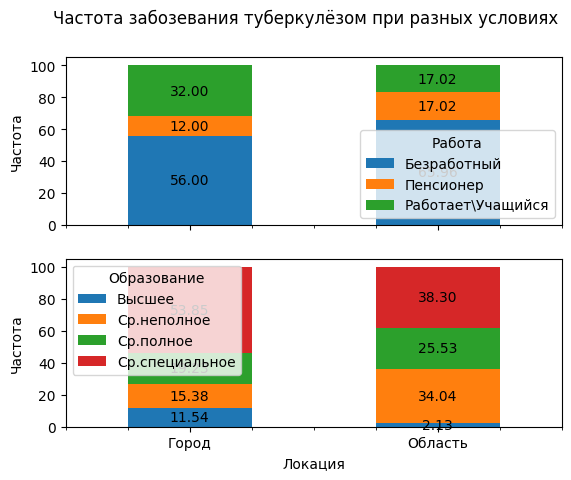

In [84]:
#@title ↓ Потом ткнуть сюда (при наведении мышки появится кружочек, надо на него нажать)

# Строим два графика в разных областях графика
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
#df.groupby('Локация')['Работа'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax1)
#df.groupby('Локация')['Образование'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax2)

col0 = "\u041B\u043E\u043A\u0430\u0446\u0438\u044F" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ", "Исход"]
col1 = "\u0420\u0430\u0431\u043E\u0442\u0430" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ",  "Исход"]
col2 = "\u041E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u043D\u0438\u0435" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ", "Исход"]


# Группируем данные по столбцу 'Локация'
grouped = df.groupby(col0)

# Получаем частоту появления значений в столбце 'Работа'
work_freq = grouped[col1].value_counts(normalize=True).unstack()*100

# Получаем частоту появления значений в столбце 'Образование'
edu_freq = grouped[col2].value_counts(normalize=True).unstack()*100

# Строим первый график
work_freq.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_ylabel('Частота')
#ax1.set_title('Работа')

# Добавляем надписи с частотой появления значений на первый график
for i in ax1.containers:
    ax1.bar_label(i, label_type='center', labels=[f'{x:.2f}' for x in i.datavalues])

# Строим второй график
edu_freq.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_ylabel('Частота')
#ax2.set_title('Образование')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# Добавляем надписи с частотой появления значений на второй график
for i in ax2.containers:
    ax2.bar_label(i, label_type='center', labels=[f'{x:.2f}' for x in i.datavalues])

# Добавляем заголовок для всего рисунка
plt.suptitle('Частота забозевания туберкулёзом при разных условиях')
plt.show()
del grouped,work_freq,edu_freq,i,fig,ax1,ax2

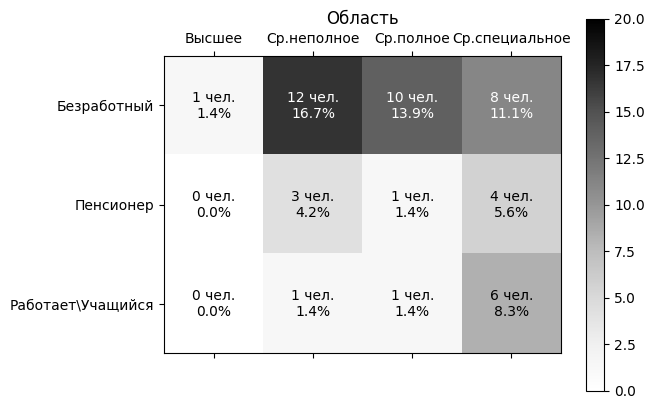

Образование,Высшее,Ср.неполное,Ср.полное,Ср.специальное
Работа,,,,
Безработный,1.388889,16.666667,13.888889,11.111111
Пенсионер,0.000000,4.166667,1.388889,5.555556
Работает\Учащийся,0.000000,1.388889,1.388889,8.333333


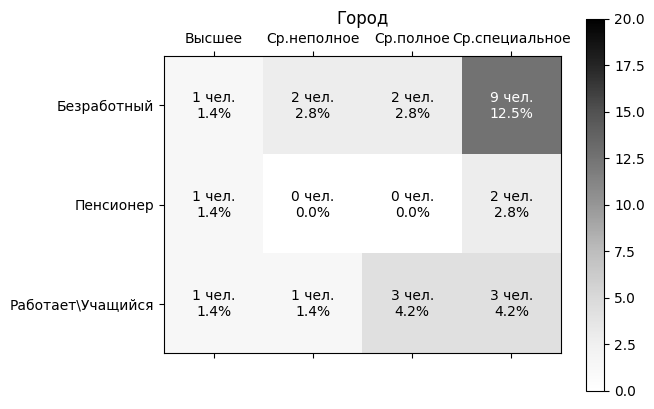

Образование,Высшее,Ср.неполное,Ср.полное,Ср.специальное
Работа,,,,
Безработный,1.388889,2.777778,2.777778,12.500000
Пенсионер,1.388889,0.000000,0.000000,2.777778
Работает\Учащийся,1.388889,1.388889,4.166667,4.166667


In [85]:
#@title Разделение по трём параметрам

col0 = "\u041B\u043E\u043A\u0430\u0446\u0438\u044F" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ", "Исход"]
norm_after_grouping = False #@param {type:"boolean"}
col1 = "\u0420\u0430\u0431\u043E\u0442\u0430" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ",  "Исход"]
col2 = "\u041E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u043D\u0438\u0435" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ", "Исход"]

freqs = df.groupby([col0, col1, col2]).size()

# Получение нормализованных частот
norm_freqs = 100 * freqs / freqs.sum()
max = np.floor(np.ceil(norm_freqs.max() / 10) * 10)

# Построение двухмерных графиков
for loc in df[col0].dropna().unique():
  subset = freqs[loc].unstack().fillna(0)
  if norm_after_grouping:
    norm_freqs[loc] = 100 * freqs[loc] / freqs[loc].sum()
  subset_norm = norm_freqs[loc].unstack().fillna(0)
  plt.matshow(subset_norm, cmap='Greys', vmin=0, vmax=max)
  plt.title(loc)
  ax = plt.gca()
  # Добавляем надписи
  for (((i,j),z1),((_,_),z2)) in zip(np.ndenumerate(subset), np.ndenumerate(subset_norm)):
      text_color = 'white' if subset_norm.iloc[i, j] > 10 else 'black'
      ax.text(j, i, '{:d} чел.\n{:0.1f}%'.format(int(z1), z2), ha='center', va='center', color=text_color)
  plt.xticks(range(len(subset_norm.columns)), subset_norm.columns)
  plt.yticks(range(len(subset_norm.index)), subset_norm.index)
  plt.colorbar()
  plt.show()
  display(HTML(subset_norm.to_html()))
del freqs,norm_freqs,subset,subset_norm,i,j,z1,z2,loc,ax,text_color,max,col0,col1,col2,norm_after_grouping

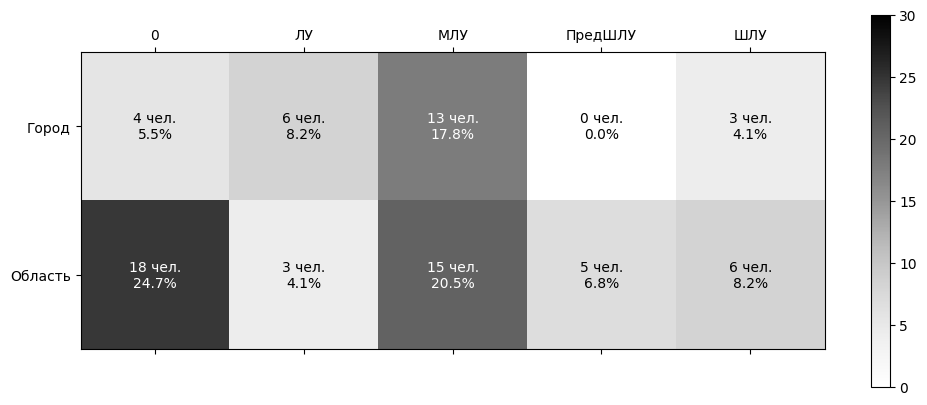

Вид ЛУ,0,ЛУ,МЛУ,ПредШЛУ,ШЛУ
Локация,,,,,
Город,5.479452,8.219178,17.808219,0.000000,4.109589
Область,24.657534,4.109589,20.547945,6.849315,8.219178


Хи-квадрат статистика: 14.95074074861309
p-значение: 0.0048044821284227305
Степени свободы: 4
Ожидаемое распределение:


Вид ЛУ,0,ЛУ,МЛУ,ПредШЛУ,ШЛУ
Локация,,,,,
Город,10.733721,4.391068,13.661100,2.439482,4.391068
Область,19.403265,7.937699,24.695065,4.409833,7.937699


In [97]:
#@title Разделение по двум параметрам
col1 = "\u041B\u043E\u043A\u0430\u0446\u0438\u044F" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ",  "Исход"]
col2 = "\u0412\u0438\u0434 \u041B\u0423" #@param ["Локация", "Регион", "Работа", "Образование", "Форма туберкулёза", "Вид ЛУ", "Исход"]

freqs = df.groupby([col1,col2]).size()
norm_freqs = 100 * freqs / freqs.sum()
max = np.floor(np.ceil(norm_freqs.max() / 10) * 10)
subset = freqs.unstack().fillna(0)
subset_norm = norm_freqs.unstack().fillna(0)
plt.matshow(subset_norm, cmap='Greys', vmin=0, vmax=max)
ax = plt.gca()
# Добавляем надписи
for (((i,j),z1),((_,_),z2)) in zip(np.ndenumerate(subset), np.ndenumerate(subset_norm)):
    text_color = 'white' if subset_norm.iloc[i, j] > 10 else 'black'
    ax.text(j, i, '{:d} чел.\n{:0.1f}%'.format(int(z1), z2), ha='center', va='center', color=text_color)
plt.xticks(range(len(subset_norm.columns)), subset_norm.columns)
plt.yticks(range(len(subset_norm.index)), subset_norm.index)
plt.colorbar()
plt.show()
display(HTML(subset_norm.to_html()))
observed_data = subset_norm.values
# Переставляем строки в соответствии с предположением
# if sum(observed_data[0]) > sum(observed_data[1]):
#    observed_data = [observed_data[1], observed_data[0]]

chi2_stat, p_val, dof, expected_data = chi2_contingency(observed_data)
print("Хи-квадрат статистика:", chi2_stat)
print("p-значение:", p_val)
print("Степени свободы:", dof)
print("Ожидаемое распределение:")
expected_data = pd.DataFrame(expected_data, index = subset_norm.index, columns = subset_norm.columns)
display(HTML(expected_data.to_html()))
del freqs,norm_freqs,subset,subset_norm,observed_data,expected_data,dof,chi2_stat,p_val,i,j,z1,z2,ax,text_color,max,col1,col2
